In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [ ]:
fb_links

In [ ]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 295347.79it/s]


In [ ]:
node_list_2

In [ ]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


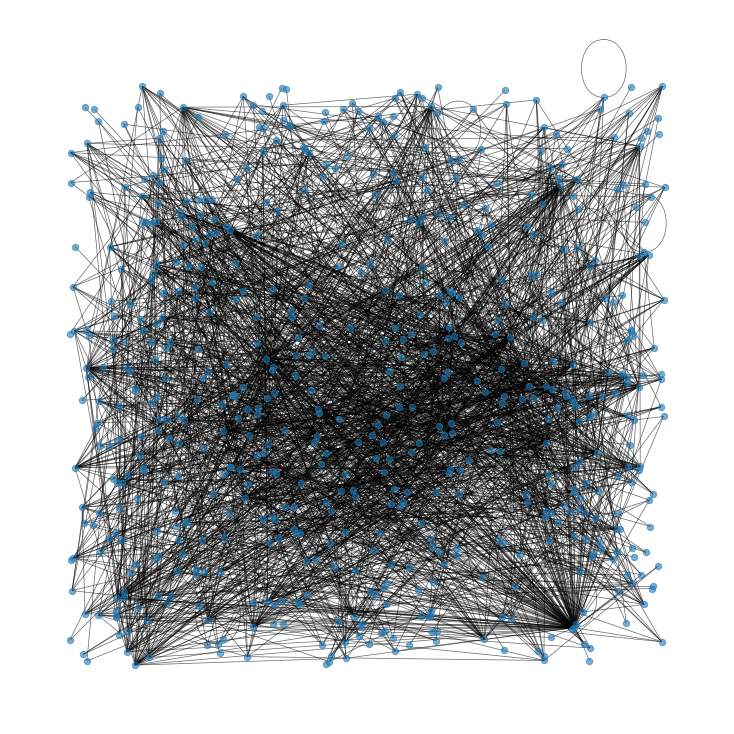

In [ ]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2
node_list


In [ ]:
# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
node_list

In [ ]:
# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
adj_G.shape
adj_G

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
adj_G[0,1]

0.0

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:12<00:00, 51.36it/s] 


In [ ]:
len(all_unconnected_pairs)
all_unconnected_pairs

In [ ]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [ ]:
# view data
data.head(10)

,node_1,node_2,link
0,0,22,0
1,0,526,0
2,0,36,0
3,0,54,0
4,0,56,0
5,0,65,0
6,0,66,0
7,0,86,0
8,0,88,0
9,0,89,0


In [ ]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:12<00:00, 166.17it/s]


In [ ]:
nx.number_connected_components(G_temp)

2

In [ ]:
len(omissible_links_index)

1483

In [ ]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
data['link'].value_counts()
#data['link']

0    19018
1     1483
Name: link, dtype: int64

In [ ]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
!pip install node2vec

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [ ]:
node2vec.d_graph

defaultdict(dict,
            {'0': {'first_travel_key': array([1.]),
              'neighbors': ['555'],
              'probabilities': {'555': array([1.])}},
             '1': {'first_travel_key': array([1.]),
              'neighbors': ['611'],
              'probabilities': {'611': array([1.])}},
             '10': {'first_travel_key': array([1.]),
              'neighbors': ['258'],
              'probabilities': {'258': array([1.])}},
             '100': {'first_travel_key': array([1.]),
              'neighbors': ['518'],
              'probabilities': {'518': array([1.])}},
             '101': {'first_travel_key': array([1.]),
              'neighbors': ['152'],
              'probabilities': {'152': array([1.])}},
             '102': {'first_travel_key': array([0.5, 0.5]),
              'neighbors': ['227', '554'],
              'probabilities': {'227': array([0.5, 0.5]),
               '554': array([0.5, 0.5])}},
             '103': {'first_travel_key': array([0.5, 0.5]),
   

In [ ]:
data

In [ ]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]
x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


[array([-0.2583876 ,  0.59908795,  0.33813453, -0.4112288 ,  0.6151531 ,
         0.91394913, -0.29224145, -0.02026108, -1.0648168 ,  0.26475754,
        -0.2313743 , -0.39450565,  0.28299952, -0.37649012,  0.00552157,
        -0.25551802,  0.31945887,  0.03416628,  0.9158648 ,  0.18278667,
        -0.50148994, -0.30642143,  0.25570026,  1.0466901 , -0.46961513,
         0.18131687, -0.12188101,  0.7570039 ,  1.342045  ,  0.04438865,
        -1.0390575 , -0.9823482 , -0.19096625, -0.5391721 ,  0.8349779 ,
        -0.46366566, -0.48616612, -0.72375333, -0.6028854 , -0.3190686 ,
         0.62822324,  1.3750863 , -0.00814262, -0.0837767 ,  0.5580354 ,
         0.16375828, -1.3623881 , -1.6338274 ,  0.5395484 , -0.3039756 ,
         0.23467153,  0.53321   ,  0.11555892, -0.6074476 , -0.15654239,
         0.9746398 ,  0.483222  , -0.31738892, -1.0019857 , -1.1568446 ,
         0.30351192, -0.83222914, -0.04049474, -0.66618955,  1.1474631 ,
        -0.3922119 , -1.3924242 ,  0.6235641 ,  0.1

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])